# Pipeline

## 1. Blocks cutting

### 1.1. Fetching data from OpenStreetMap. 
The step can be skipped, if the data already exists.

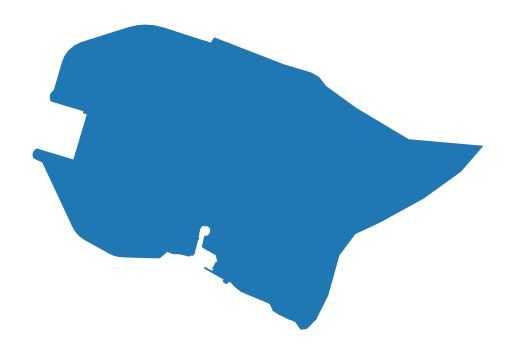

In [1]:
import osmnx as ox

boundaries = ox.geocode_to_gdf('Санкт-Петербург, Василеостровский район')
boundaries.plot().set_axis_off()

In [2]:
bc_tags = {
    'roads': {
      "highway": ["construction","crossing","living_street","motorway","motorway_link","motorway_junction","pedestrian","primary","primary_link","raceway","residential","road","secondary","secondary_link","services","tertiary","tertiary_link","track","trunk","trunk_link","turning_circle","turning_loop","unclassified",],
      "service": ["living_street", "emergency_access"]
    },
    'railways': {
      "railway": "rail"
    },
    'water': {
      'riverbank':True,
      'reservoir':True,
      'basin':True,
      'dock':True,
      'canal':True,
      'pond':True,
      'natural':['water','bay'],
      'waterway':['river','canal','ditch'],
      'landuse':'basin',
      'water': 'lake'
    }
}

In [3]:
water = ox.features_from_polygon(boundaries.union_all(), bc_tags['water'])
roads = ox.features_from_polygon(boundaries.union_all(), bc_tags['roads'])
railways = ox.features_from_polygon(boundaries.union_all(), bc_tags['railways'])

In [4]:
water = water[water.geom_type.isin(['Polygon', 'MultiPolygon', 'LineString', 'MultiLineString'])].copy()
roads = roads[roads.geom_type.isin(['LineString', 'MultiLineString'])].copy()
railways = railways[railways.geom_type.isin(['LineString', 'MultiLineString'])].copy()

In [5]:
crs = boundaries.estimate_utm_crs()

for gdf in [water, roads, railways, boundaries]:
  gdf.to_crs(crs, inplace=True)

### 1.2. Preprocessing input geometry

The step can be skipped if input geometries are already sorted as lines, polygons and boundary.

In [6]:
from blocksnet.blocks.cutting import preprocess_urban_objects, cut_urban_blocks

lines, polygons = preprocess_urban_objects(roads, railways, water)

2025-05-15 13:54:00.848 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:36 - Checking roads schema
2025-05-15 13:54:00.893 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:42 - Checking railways schema
2025-05-15 13:54:00.906 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:48 - Checking water schema


### 1.3. Cutting urban blocks

In [7]:
blocks = cut_urban_blocks(boundaries, lines, polygons)

2025-05-15 13:54:00.939 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:20 - Checking boundaries schema
2025-05-15 13:54:00.953 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:24 - Checking line objects schema
2025-05-15 13:54:00.974 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:30 - Checking polygon objects schema
2025-05-15 13:54:00.989 | INFO     | blocksnet.blocks.cutting.processing.core:_exclude_polygons:45 - Excluding polygon objects from blocks
2025-05-15 13:54:01.494 | INFO     | blocksnet.blocks.cutting.processing.core:_get_enclosures:51 - Setting up enclosures
2025-05-15 13:54:01.539 | INFO     | blocksnet.blocks.cutting.processing.core:_fill_holes:68 - Filling holes inside the blocks
2025-05-15 13:54:01.571 | INFO     | blocksnet.blocks.cutting.processing.core:_filter_overlapping:78 - Filtering overlapping geometries
2025-05-15 13:54:01.637 | SUCCESS  | blocksnet.blocks.cutting.processing.core:cut_urban_blocks:119 - Blocks are succ

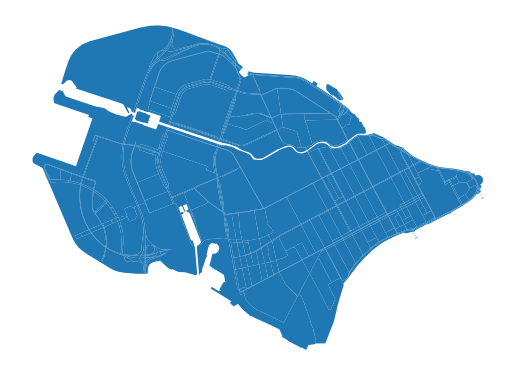

In [8]:
blocks.plot().set_axis_off()

## 2. Land use assignment

### 2.1. Fetching data from OpenStreetMap

The step can be skipped if functional zones layer is already obtained via goverment sources.

In [22]:
import osmnx as ox

functional_zones = ox.features_from_polygon(boundaries.to_crs(4326).union_all(), tags={'landuse': True})

In [23]:
functional_zones = functional_zones.reset_index(drop=True)[['geometry','landuse']].rename(columns={'landuse': 'functional_zone'})
functional_zones = functional_zones.to_crs(crs)
functional_zones.head()

,geometry,functional_zone
0,"POLYGON ((345659.049 6646239.362, 345672.29 66...",commercial
1,"POLYGON ((346755.014 6647579.789, 346728.91 66...",industrial
2,"POLYGON ((345964.693 6646155.952, 346283.885 6...",industrial
3,"POLYGON ((345753.722 6648393.897, 345900.252 6...",cemetery
4,"POLYGON ((345900.252 6648481.707, 345896.076 6...",garages


### 2.2. Specifying rules

Rules define how `functional_zone` column will be mapped into `LandUse`.

In [26]:
from blocksnet.enums import LandUse

rules = {
  'commercial': LandUse.BUSINESS,
  'industrial': LandUse.INDUSTRIAL,
  'cemetery': LandUse.SPECIAL,
  'garages': LandUse.INDUSTRIAL,
  'residential': LandUse.RESIDENTIAL,
  'retail': LandUse.BUSINESS,
  'grass': LandUse.RECREATION,
  'farmland': LandUse.AGRICULTURE,
  'construction': LandUse.SPECIAL,
  'brownfield': LandUse.INDUSTRIAL,
  'forest': LandUse.RECREATION,
  'recreation_ground': LandUse.RECREATION,
  'religious': LandUse.SPECIAL,
  'flowerbed': LandUse.RECREATION,
  'military': LandUse.SPECIAL,
  'landfill': LandUse.TRANSPORT
}

### 2.3. Assignment

In [27]:
from blocksnet.blocks.assignment import assign_land_use

blocks = assign_land_use(blocks, functional_zones.reset_index(drop=True).rename(columns={'landuse': 'functional_zone'}), rules)

2025-05-15 14:04:10.575 | INFO     | blocksnet.blocks.assignment.core:assign_land_use:44 - Overlaying geometries
2025-05-15 14:04:10.712 | SUCCESS  | blocksnet.blocks.assignment.core:assign_land_use:55 - Shares calculated


In [25]:
blocks.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share
0,"POLYGON ((345747.414 6646456.191, 345751.077 6...",0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,None,NaN
1,"POLYGON ((345751.077 6646449.404, 345747.414 6...",0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,None,NaN
2,"POLYGON ((345047.432 6648157.204, 345028.835 6...",0.496234,0.093738,0.115348,0.0,0.0,0.000000,0.0,LandUse.RESIDENTIAL,0.496234
3,"POLYGON ((344951.065 6648110.08, 344977.865 66...",0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,None,NaN
4,"POLYGON ((346686.09 6647227.682, 346691.412 66...",0.173093,0.116007,0.005135,0.0,0.0,0.167767,0.0,LandUse.RESIDENTIAL,0.173093


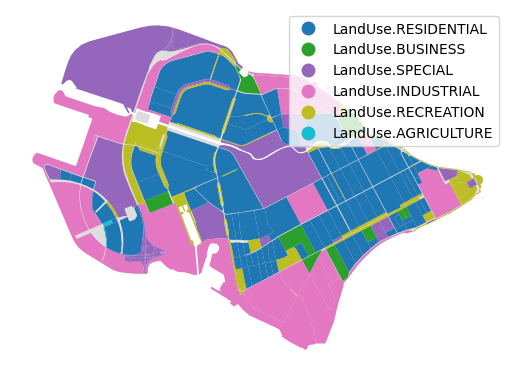

In [29]:
ax = blocks.plot(color='#ddd')
blocks.plot(column='land_use', legend=True, ax=ax).set_axis_off()

## 3. Accessibility matrix calculation

There are few ways to define spatial relations between urban blocks:
- **Accessibility matrix** -- `n^2` matrix that defines travel time between urban blocks' centroids in minutes.
- **Distance matrix** -- `n^2` matrix that defines euclidian distance between urban blocks' centroids in meters.
- **Adjacency graph** -- graph with `n` nodes. Each edge of this graph indicates spatial adjacency of two urban blocks.

In this example the **accessibility matrix** will be calculated using `IduEdu` library.

### 3.1. Intermodal graph construction

There are few types of city graphs to model city network:
- **walk** -- pedestrian network.
- **drive** -- personal transport network.
- **intermodal** -- pedestrian and public transport network.

In this example **intermodal** graph will be constructed, but overall it depends on one's research.

In [31]:
from blocksnet.relations import get_accessibility_graph

graph = get_accessibility_graph(boundaries, 'intermodal')

2025-05-15 14:22:14.709 | WARNING  | blocksnet.relations.accessibility.graph:get_accessibility_graph:14 - CRS do not match IDUEDU required crs. Reprojecting
2025-05-15 14:22:14.717 | INFO     | iduedu.modules.drive_walk_builder:get_walk_graph:217 - Downloading walk graph from OSM, it may take a while for large territory ...


Parsing public transport routes:   0%|          | 0/61 [00:00<?, ?it/s]

Calculating the weights of the walk graph:   0%|          | 0/49364 [00:00<?, ?it/s]

2025-05-15 14:22:48.386 | INFO     | iduedu.modules.pt_walk_joiner:join_pt_walk_graph:51 - Composing intermodal graph...
2025-05-15 14:22:52.566 | WARNING  | iduedu.utils.utils:remove_weakly_connected_nodes:37 - Removing 555 nodes that form 269 trap components. These are groups where you can enter but can't exit (or vice versa). Keeping the largest strongly connected component (20350 nodes).


### 3.2. Calculating the accessibility matrix

In [33]:
from blocksnet.relations import calculate_accessibility_matrix

acc_mx = calculate_accessibility_matrix(blocks, graph)

In [34]:
acc_mx.head()

,0,1,2,3,4,5,6,7,8,9,...,574,575,576,577,578,579,580,581,582,583
0,0.000000,0.623535,13.679688,9.679688,7.523438,11.148438,18.71875,15.585938,17.484375,14.890625,...,25.015625,13.789062,12.218750,13.820312,15.375000,14.859375,16.125000,21.109375,12.625000,20.078125
1,0.623535,0.000000,13.531250,9.531250,7.371094,10.992188,18.56250,15.437500,17.328125,14.742188,...,24.859375,13.640625,12.070312,13.664062,15.218750,14.703125,15.976562,20.953125,12.468750,19.921875
2,13.398438,13.250000,0.000000,5.152344,17.250000,16.937500,19.37500,13.445312,15.343750,12.750000,...,19.453125,11.640625,9.250000,11.679688,9.804688,9.281250,10.554688,17.046875,21.250000,15.898438
3,11.750000,11.593750,5.152344,0.000000,14.585938,14.187500,16.68750,10.742188,12.648438,10.046875,...,18.562500,8.460938,7.371094,8.843750,8.921875,8.398438,9.671875,16.171875,19.250000,15.015625
4,7.953125,8.296875,17.281250,13.273438,0.000000,6.140625,16.90625,16.062500,15.890625,17.515625,...,28.625000,17.390625,15.812500,17.421875,18.984375,18.453125,19.734375,24.718750,15.265625,23.687500


## 4. Buildings aggregation

Buildings define the urban environment parameters in different blocks. For some blocksnet methods only population can be used, but overall the building is defined via:

- `population : float`
- `footprint_area : float` -- building's base area
- `number_of_floors : float`
- `build_floor_area : float` -- sum area of each building floor
- `is_living : bool`
- `living_area : float` -- area defined for residents
- `non_living_area : float` -- area not defined to live in

Some of these parameters may be optional, depends on what one already has.

### 4.1. Fetching data from OpenStreetMap

The step can be skipped if the data already obtained from any available source.

In [70]:
buildings = ox.features_from_polygon(boundaries.to_crs(4326).union_all(), tags={'building': True}).reset_index(drop=True).to_crs(crs)

#### 4.1.1. `is_living`

In [71]:
is_living_tags = ['residential', 'house', 'apartments', 'detached', 'terrace', 'dormitory']
buildings['is_living'] = buildings['building'].apply(lambda b : b in is_living_tags)

#### 4.1.2. `number_of_floors`

In [72]:
import pandas as pd

buildings['number_of_floors'] = pd.to_numeric(buildings['building:levels'], errors='coerce')

### 4.2. Imputing missing data

In [73]:
from blocksnet.preprocessing.imputing import impute_buildings

buildings = impute_buildings(buildings, default_living_demand=30)

2025-05-15 17:35:18.264 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column footprint_area not found and will be initialized as None
2025-05-15 17:35:18.266 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column build_floor_area not found and will be initialized as None
2025-05-15 17:35:18.267 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column living_area not found and will be initialized as None
2025-05-15 17:35:18.268 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column non_living_area not found and will be initialized as None
2025-05-15 17:35:18.269 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column population not found and will be initialized as None


In [74]:
buildings.sample(5)

,geometry,is_living,number_of_floors,footprint_area,build_floor_area,living_area,non_living_area,population
889,"POLYGON ((345264.188 6646887.671, 345393.166 6...",False,1.0,4721.537098,4721.537098,0.000000,4721.537098,NaN
995,"POLYGON ((346363.271 6646722.165, 346376.83 66...",False,1.0,511.598411,511.598411,0.000000,511.598411,NaN
1769,"POLYGON ((347695.061 6647437.311, 347698.738 6...",False,1.0,1262.768452,1262.768452,0.000000,1262.768452,NaN
432,"POLYGON ((345161.575 6649283.203, 345162.035 6...",True,12.0,1098.752073,13185.024871,11866.522384,1318.502487,395.0
330,"POLYGON ((346463.218 6645779.296, 346489.916 6...",False,1.0,1215.746209,1215.746209,0.000000,1215.746209,NaN


In [75]:
buildings.population.sum()

np.float64(271251.0)

### 4.3. Aggregating buildings within blocks

In [79]:
from blocksnet.blocks.aggregation import aggregate_objects

buildings_blocks = aggregate_objects(blocks, buildings)[0]

2025-05-15 17:41:57.819 | INFO     | blocksnet.blocks.aggregation.core:_preprocess_input:12 - Preprocessing input
2025-05-15 17:41:57.829 | INFO     | blocksnet.blocks.aggregation.core:aggregate_objects:41 - Aggregating objects


In [80]:
buildings_blocks.head()

,geometry,is_living,number_of_floors,footprint_area,build_floor_area,living_area,non_living_area,population,objects_count
0,"POLYGON ((345747.414 6646456.191, 345751.077 6...",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,"POLYGON ((345751.077 6646449.404, 345747.414 6...",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,"POLYGON ((345047.432 6648157.204, 345028.835 6...",18.0,287.0,67273.384879,386154.823127,295058.918381,91095.904746,9827.0,72.0
3,"POLYGON ((344951.065 6648110.08, 344977.865 66...",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,"POLYGON ((346686.09 6647227.682, 346691.412 66...",1.0,32.0,3411.837763,54589.404201,24939.758056,29649.646145,831.0,2.0


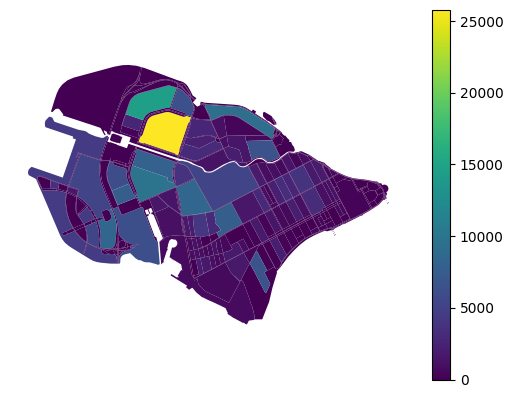

In [81]:
buildings_blocks.plot('population', legend=True).set_axis_off()

## 5. Services aggregation